1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd
import numpy as np
file_name = "./data/data_000637.txt"
N = 200000
data = pd.read_csv(file_name, nrows = N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
199995,1,0,139,3869202157,76,0
199996,1,0,62,3869202157,76,2
199997,1,1,2,3869202157,94,15
199998,1,1,1,3869202157,96,13


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
df = data.loc[:, ['ORBIT_CNT', 'BX_COUNTER']].groupby('ORBIT_CNT').transform(np.max)
print(df)
x = df['BX_COUNTER'].unique().mean()
print(x)

        BX_COUNTER
0             3187
1             3187
2             3187
3             3187
4             3187
...            ...
199995         107
199996         107
199997         107
199998         107
199999         107

[200000 rows x 1 columns]
2884.7844712182064


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [4]:
data['TOTAL_TIME_timestamp'] = data['ORBIT_CNT']*x*25 + data['BX_COUNTER']*25 + data['TDC_MEAS']*(25/30)
print(data)
import datetime as dt
#data['TOTAL_TIME_C'] = dt.datetime.fromtimestamp(data.loc[:, ['TOTAL_TIME']]//1000000000) 
#data['TOTAL_TIME_C'] = pd.to_datetime(data.loc[:, ['TOTAL_TIME']]*10^3, format='%f')
#c = pd.Timestamp(data['TOTAL_TIME']*10^3, unit='ns')
#df2 = pd.Timestamp(data.loc[:, ['TOTAL_TIME']], unit='ns')
#ts = pd.to_datetime(str(data['TOTAL_TIME']*10^3), format='%f')
#print(c.value)
data['TOTAL_TIME_ns'] = pd.to_datetime(data['TOTAL_TIME_timestamp'], unit='ns')
print(data)

        HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0          1     0          123  3869200167        2374        26   
1          1     0          124  3869200167        2374        27   
2          1     0           63  3869200167        2553        28   
3          1     0           64  3869200167        2558        19   
4          1     0           64  3869200167        2760        25   
...      ...   ...          ...         ...         ...       ...   
199995     1     0          139  3869202157          76         0   
199996     1     0           62  3869202157          76         2   
199997     1     1            2  3869202157          94        15   
199998     1     1            1  3869202157          96        13   
199999     1     1            3  3869202157         107        19   

        TOTAL_TIME_timestamp  
0               2.790452e+14  
1               2.790452e+14  
2               2.790452e+14  
3               2.790452e+14  
4               

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [5]:
data
s = pd.Series([data.iloc[0, 7], data.iloc[-1, 7]])
s.diff()

0                         NaT
1   0 days 00:00:00.143461347
dtype: timedelta64[ns]

5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
df = data.loc[:, ['TDC_CHANNEL','ORBIT_CNT']].groupby('TDC_CHANNEL').count()
df.sort_values(by='ORBIT_CNT', ascending=False)
df.rename(columns = {'ORBIT_CNT':'TDC_COUNT'}, inplace = True)
print(df)
print(df.loc[1:3, ['TDC_COUNT']])

             TDC_COUNT
TDC_CHANNEL           
1                 4484
2                 5171
3                 3544
4                 4307
5                 2464
...                ...
129                  7
130                 15
137                 11
138                 11
139              16627

[133 rows x 1 columns]
             TDC_COUNT
TDC_CHANNEL           
1                 4484
2                 5171
3                 3544


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [7]:
ne_o = len(data.groupby('ORBIT_CNT')['ORBIT_CNT'].count())
ne_o

1989

7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [8]:
orbits = data.loc[data['TDC_CHANNEL'] == 139, 'ORBIT_CNT'].unique()
n = len(orbits)
print(n)

1987


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [9]:
fpga_0 = data.loc[data['FPGA']==0].groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()
print(fpga_0)
fpga_1 = data.loc[data['FPGA']==1].groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()
fpga_1

TDC_CHANNEL
1        187
2        233
3        229
4        325
5        232
       ...  
129        1
130        7
137        5
138        5
139    11665
Name: TDC_CHANNEL, Length: 122, dtype: int64


TDC_CHANNEL
1      4297
2      4938
3      3315
4      3982
5      2232
       ... 
129       6
130       8
137       6
138       6
139    4962
Name: TDC_CHANNEL, Length: 132, dtype: int64

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

<AxesSubplot:xlabel='TDC_CHANNEL'>

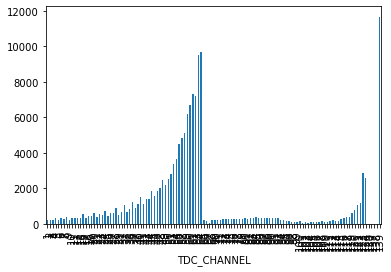

In [10]:
import matplotlib.pyplot as plt
#plt.plot(fpga_0.iloc[0], fpga_0.iloc[1])
fpga_0.plot(kind='bar')


<AxesSubplot:xlabel='TDC_CHANNEL'>

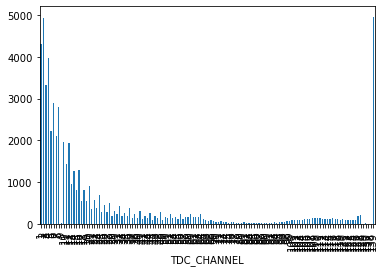

In [11]:
fpga_1.plot(kind='bar')